In [25]:
import argparse
import os
import operator
import pickle

import csv
import datetime
from collections import Counter
import numpy as np
import time

In [26]:
parser = argparse.ArgumentParser()
parser.add_argument('--save-dir', default='retailrocket_temp', help='save directory name')
opt = parser.parse_args([])
print(opt)

Namespace(save_dir='retailrocket_temp')


In [27]:
print("-- Starting @ %ss" % datetime.datetime.now())

if not os.path.exists(f'../{opt.save_dir}'):
    os.makedirs(f'../{opt.save_dir}')

with open("../raw/events.csv", "r") as f:
    lines = f.readlines()
    user_dict = {}
    items_freq = {}

    for line in lines[1:]:
        data = line.strip('\n').split(',')
        timestamp = int(int(data[0]) / 1000)
        user = data[1]
        item = data[3]
        new_line = [timestamp, user, item]

        if user in user_dict.keys():
            user_dict[user] += [new_line]
        else:
            user_dict[user] = [new_line]
        
        if item in items_freq:
            items_freq[item] += 1
        else:
            items_freq[item] = 1

-- Starting @ 2022-10-10 16:58:34.314445s


KeyboardInterrupt: 

In [4]:
if len(items_freq) > 40000:
    items_freq = dict(sorted(items_freq.items(), key=lambda d: d[1], reverse=True)[:40000])

rr_data = open(f"../{opt.save_dir}/retailrocket_data.csv", "w")
writer = csv.writer(rr_data)
writer.writerow(["SessionId","TimeStamp","ItemId"])
sessid = 0
for user in user_dict.keys():
    user_dict[user] = sorted(user_dict[user], key=lambda x: x[1])
    curdate = None
    
    for record in user_dict[user]:
        item_id = record[2]
        # if len(item_id) >= 2:
        if len(item_id) >= 2 and item_id in items_freq:
            sess_date = record[0]
            if curdate and sess_date-curdate > 28800:
                sessid += 1
            curdate = sess_date
            new_record = [str(sessid), str(record[0]), record[2]]
            writer.writerow(new_record)  
    sessid += 1  

In [5]:
print("-- Allocating Session ids @ %ss" % datetime.datetime.now())

with open(f'../{opt.save_dir}/retailrocket_data.csv', "r") as f:
    reader = csv.DictReader(f, delimiter=',')
    sess_clicks = {}
    sess_date = {}
    ctr = 0
    curid = -1
    curdate = None
    for data in reader:
        sessid = int(data['SessionId'])
        if curdate and curid != sessid:
            date = ''
            date = curdate
            sess_date[curid] = date
        curid = sessid
        item = int(data['ItemId']), float(data['TimeStamp'])
        curdate = ''
        curdate = float(data['TimeStamp'])

        if sessid in sess_clicks:
            sess_clicks[sessid] += [item]
        else:
            sess_clicks[sessid] = [item]
        ctr += 1
    date = curdate

    for i in list(sess_clicks):
        sorted_clicks = sorted(sess_clicks[i], key=operator.itemgetter(1))
        sess_clicks[i] = [c[0] for c in sorted_clicks]
    sess_date[curid] = date
print("-- Reading data @ %ss" % datetime.datetime.now())

-- Allocating Session ids @ 2022-10-10 16:48:36.729815s
-- Reading data @ 2022-10-10 16:48:55.229551s


In [6]:
# Filter out length 1 sessions
for s in list(sess_clicks):
    if len(sess_clicks[s]) < 2:
        del sess_clicks[s]
        del sess_date[s]

# Count number of times each item appears
iid_counts = {}
for s in sess_clicks:
    seq = sess_clicks[s]
    for iid in seq:
        if iid in iid_counts:
            iid_counts[iid] += 1
        else:
            iid_counts[iid] = 1

sorted_counts = sorted(iid_counts.items(), key=operator.itemgetter(1))

length = len(sess_clicks)
for s in list(sess_clicks):
    curseq = sess_clicks[s]
    filseq = list(filter(lambda i: iid_counts[i] >= 5, curseq))
    
    if len(filseq) < 2:
        del sess_clicks[s]
        del sess_date[s]
    else:
        sess_clicks[s] = filseq

In [7]:
# Split out test set based on dates
dates = list(sess_date.items())
maxdate = dates[0][1]

for _, date in dates:
    if maxdate < date:
        maxdate = date

# the last of 100 seconds for test
splitdate = maxdate - 86400 * 7

print('Splitting date', splitdate)      # Yoochoose: ('Split date', 1411930799.0)
tra_sess = filter(lambda x: x[1] < splitdate, dates)
tes_sess = filter(lambda x: x[1] > splitdate, dates)

# Sort sessions by date
tra_sess = sorted(tra_sess, key=operator.itemgetter(1))     # [(session_id, timestamp), (), ]
tes_sess = sorted(tes_sess, key=operator.itemgetter(1))     # [(session_id, timestamp), (), ]
print(f'# train sessions: {len(tra_sess)}')    # 186670    # 7966257
print(f'# test sessions: {len(tes_sess)}')    # 15979     # 15324
print(f'train sessions example: {tra_sess[:3]}')
print(f'test sessions example: {tes_sess[:3]}')

Splitting date 1441940209.0
# train sessions: 308353
# test sessions: 12011
train sessions example: [(889297, 1430622029.0), (890221, 1430622045.0), (889309, 1430622067.0)]
test sessions example: [(819275, 1441940232.0), (819305, 1441940237.0), (816962, 1441940272.0)]


In [9]:
item_dict, item_cnt = {}, {}

# train
train_ids, train_seqs, train_dates = [], [], []
item_ctr = 1
for s, date in tra_sess:
    seq = sess_clicks[s]
    outseq = []
    for i in seq:
        if i in item_dict:
            outseq += [item_dict[i]]
            item_cnt[item_dict[i]] += 1
        else:
            outseq += [item_ctr]
            item_dict[i] = item_ctr
            item_cnt[item_dict[i]] = 1
            item_ctr += 1
    if len(outseq) < 2:  # Doesn't occur
        continue
    train_ids += [s]
    train_dates += [date]
    train_seqs += [outseq]

    
# test
test_ids, test_seqs, test_dates = [], [], []
for s, date in tes_sess:
    seq = sess_clicks[s]
    outseq = []
    for i in seq:
        if i in item_dict:
            outseq += [item_dict[i]]
    if len(outseq) < 2:
        continue
    test_ids += [s]
    test_dates += [date]
    test_seqs += [outseq]

In [10]:
def process_seqs(iseqs, idates, train=True):
    out_seqs, labs = [], []
    
    if train:
        out_dates, ids = [], []

        for id, seq, date in zip(range(len(iseqs)), iseqs, idates):
            for i in range(1, len(seq)):
                tar = seq[-i]
                labs += [tar]
                out_seqs += [seq[:-i]]
                out_dates += [date]
                ids += [id]
        return out_seqs, out_dates, labs, ids
    else:
        for seq in iseqs:
            labs += [seq[-1]]
            out_seqs += [seq[:-1]]
        return out_seqs, labs

In [11]:
tra_seqs, tra_dates, tra_labs, tra_ids = process_seqs(train_seqs, train_dates)
tes_seqs, tes_labs = process_seqs(test_seqs, None, False)

In [12]:
print(max(tes_seqs), max(tes_labs), max(tra_seqs), max(tes_labs))

[36266, 36266] 36266 [36266] 36266


In [15]:
print(min(item_dict.values()), max(item_dict.values()))

1 36266


In [16]:
print(f"# train sessions {len(tra_seqs)}, ex. {tra_seqs[:3], tra_labs[:3]}")
print(f"# test sessions {len(tes_seqs)}, ex. {tes_seqs[:3], tes_labs[:3]}")
print(f"# train clicks {sum(item_cnt.values())}")
print(f"# items {len(item_cnt.keys())}")
print(f"avg. length : {sum(map(len, tra_seqs)) / len(tra_seqs)}")

# train sessions 851962, ex. ([[1, 1], [1], [2]], [1, 1, 2])
# test sessions 11999, ex. ([[1715], [4458], [13126]], [1715, 10098, 13126])
# train clicks 1160315
# items 36266
avg. length : 6.5181181789798135


In [17]:
tra = (tra_seqs, tra_labs)
tes = (tes_seqs, tes_labs)

In [18]:
pickle.dump(tra, open(f'../{opt.save_dir}/train.txt', 'wb'))
pickle.dump(tes, open(f'../{opt.save_dir}/test.txt', 'wb'))
pickle.dump(len(item_cnt.keys()) + 1, open(f'../{opt.save_dir}/n_node.txt', 'wb'))

In [19]:
# Popularity dict
total_ctr = sum(item_cnt.values())
pop_dict = {key : (value / total_ctr) for key, value in item_cnt.items()}

pickle.dump(pop_dict, open(f"../{opt.save_dir}/pop_dict.pickle", "wb"))

In [23]:
print(min(pop_dict.values()), np.mean(list(pop_dict.values())), max(pop_dict.values()))

8.618349327553294e-07 2.7574036287431753e-05 0.0017676234470811805


In [24]:
# head tail dict 
sorted_item_cnt = sorted(item_cnt.items(), reverse=True, key=lambda item: item[1])
sorted_keys = np.array(sorted_item_cnt)[:, 0].astype(int)
sorted_values = np.array(sorted_item_cnt)[:, 1]

split_point = int(len(sorted_keys) * 0.2)
point_cnt_value = sorted_values[split_point]
split_idx = [i for i, cnt in enumerate(sorted_values) if cnt == (point_cnt_value-1)][0]

ht_dict = dict()
ht_dict['head'] = sorted_keys[:split_idx]
ht_dict['tail'] = sorted_keys[split_idx:]

print(f'# head items : {len(ht_dict["head"])}, # tail items : {len(ht_dict["tail"])}')
pickle.dump(ht_dict, open(f'../{opt.save_dir}/ht_dict.pickle', 'wb'))

# head items : 7311, # tail items : 28955


<BarContainer object of 36266 artists>

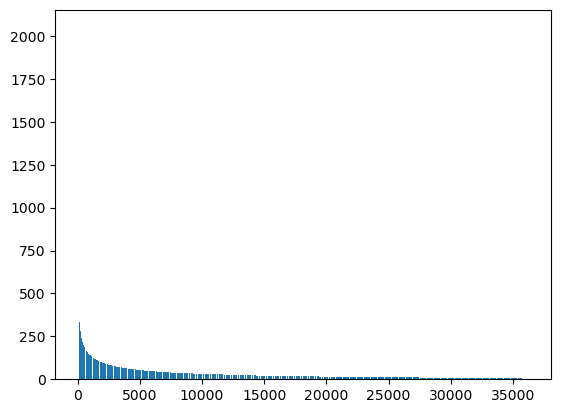

In [35]:
import matplotlib.pyplot as plt
plt.bar(np.arange(len(sorted_keys)), sorted_values)

In [36]:
sum_sorted_values = sum(sorted_values)
print(sum_sorted_values, sum_sorted_values*0.8)

1160315 928252.0


In [38]:
summ = 0
for i, value, in enumerate(sorted_values):
    summ += value
    if summ > sum_sorted_values*0.8:
        print(i, value)
        break

16125 20


In [41]:
summ = 0
for i, value, in enumerate(sorted_values):
    summ += value
    if value < 21:
        print(i, value)
        break

15745 20


In [43]:
sum(sorted_values[:15745])

920634

<BarContainer object of 20521 artists>

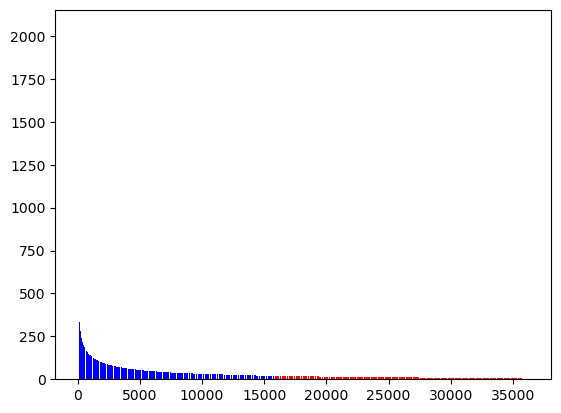

In [44]:
import matplotlib.pyplot as plt
plt.bar(np.arange(15745), sorted_values[:15745], color='blue')
plt.bar(np.arange(15745, len(sorted_values)), sorted_values[15745:], color='red')

<BarContainer object of 28955 artists>

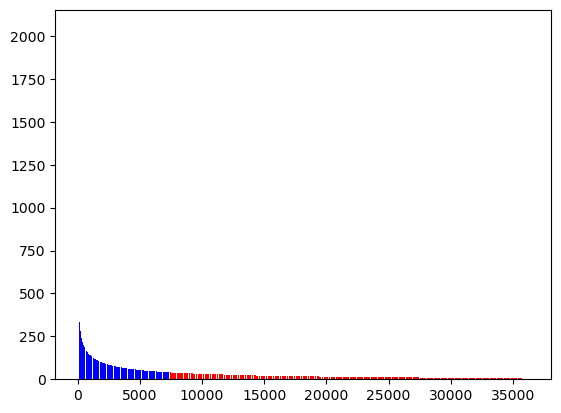

In [45]:
import matplotlib.pyplot as plt
plt.bar(np.arange(7311), sorted_values[:7311], color='blue')
plt.bar(np.arange(7311, len(sorted_values)), sorted_values[7311:], color='red')